<a href="https://colab.research.google.com/github/Portego-00/cs5356-docs/blob/main/Music_Generation_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the required libraries

In [ ]:
# For the music
from music21 import *

# For importing the songs
import os

# Utilities for preprocessing
from collections import Counter
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# For the lstm model
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [ ]:
# Setting up the MuseScore to display the notes
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

## Import the songs

In [ ]:
# Importing the songs as midi files, and save them into an array
songList = []
dirList = os.listdir('Songs')
for i in dirList:
    songList.append(converter.parse('Songs/' + i))

In [ ]:
print(songList)

[<music21.stream.Score 0x1ab13081070>, <music21.stream.Score 0x1ab16940c70>, <music21.stream.Score 0x1ab2cf24c70>, <music21.stream.Score 0x1aae76cbd00>, <music21.stream.Score 0x1aac7f7c790>, <music21.stream.Score 0x1aac81ebb50>, <music21.stream.Score 0x1aae76cbe20>, <music21.stream.Score 0x1aac8491f10>, <music21.stream.Score 0x1aac8491ee0>]


## Extract the notes and chords from the imported songs

We define a function to get the notes out of all the songs we have imported. This function will partition each song into instruments, and get all the notes and chords, and save those in order into an array.

In [ ]:
def get_notes(songList):
    """ Extract the notes and chords from the song files into an array of strings
    
    Args:
        songList: List containing the music21.stream.Score for each imported song
        
    Returns:
        notes: List of strings containing the notes and chords of the songs in order
        
    """
    notes = []
    for i in songList:
        inst = instrument.partitionByInstrument(i)
        for part in inst.parts:
            elements = part.recurse()
            for element in elements:
                # For each element, we check if it is a note or a chord
                if isinstance(element, note.Note):
                    # A note will have the following form: e.g. 'F3', 'A2', 'G2'...
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # A chord will have the following form: e.g. '9.0.4', '11.4', '4.9'
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

In [ ]:
songNotes = get_notes(songList)
print('\033[1m' + 'Total notes in these songs:' + '\033[0m', len(songNotes))

Total notes in these songs: 13565


## Change data into a suitable format

Now we want to be able to take an array of song notes (as the one we created out of the imported data), and transform it so that we can use the MuseScore library, and display the notes into a music sheet, or even play these notes.

In [ ]:
def transform_to_notes_and_chords(songNotes):
    """ Function to transform the format of a list of notes and chords into a suitable
    format for the MuseScore library. This way we are able to display the notes or even
    create a mid file to play the song.
    
    Args:
        songNotes: List of strings containing the notes and chords of the songs in order
    
    Returns:
        melodyStream: music21.stream.Stream, which is the suitable format for displaying
        or playing the notes
    
    """
    lst = []
    idx = 0
    for i in songNotes:
        # First, we check if we have a chord or a note
        if ("." in i or i.isdigit()):
            # If its a chord, we split the chord into notes
            chord_notes = i.split(".")
            notes = [] 
            for j in chord_notes:
                # We transform the chord into multiple notes, and append those to the 
                # resulting array
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = idx
                lst.append(chord_snip)
        else: 
            note_snip = note.Note(i)
            note_snip.offset = idx
            lst.append(note_snip)
        # Finally, we increase the offset each iteration so that notes do not stack
        idx += 1
    melodyStream = stream.Stream(lst)   
    return melodyStream

In [ ]:
print(transform_to_notes_and_chords(songNotes[500:600]))

<music21.stream.Stream 0x1aae189df70>


Now, to check if it works, we will show the sheet for the first 100 notes, and we will generate the melody out of those notes in a midi format.

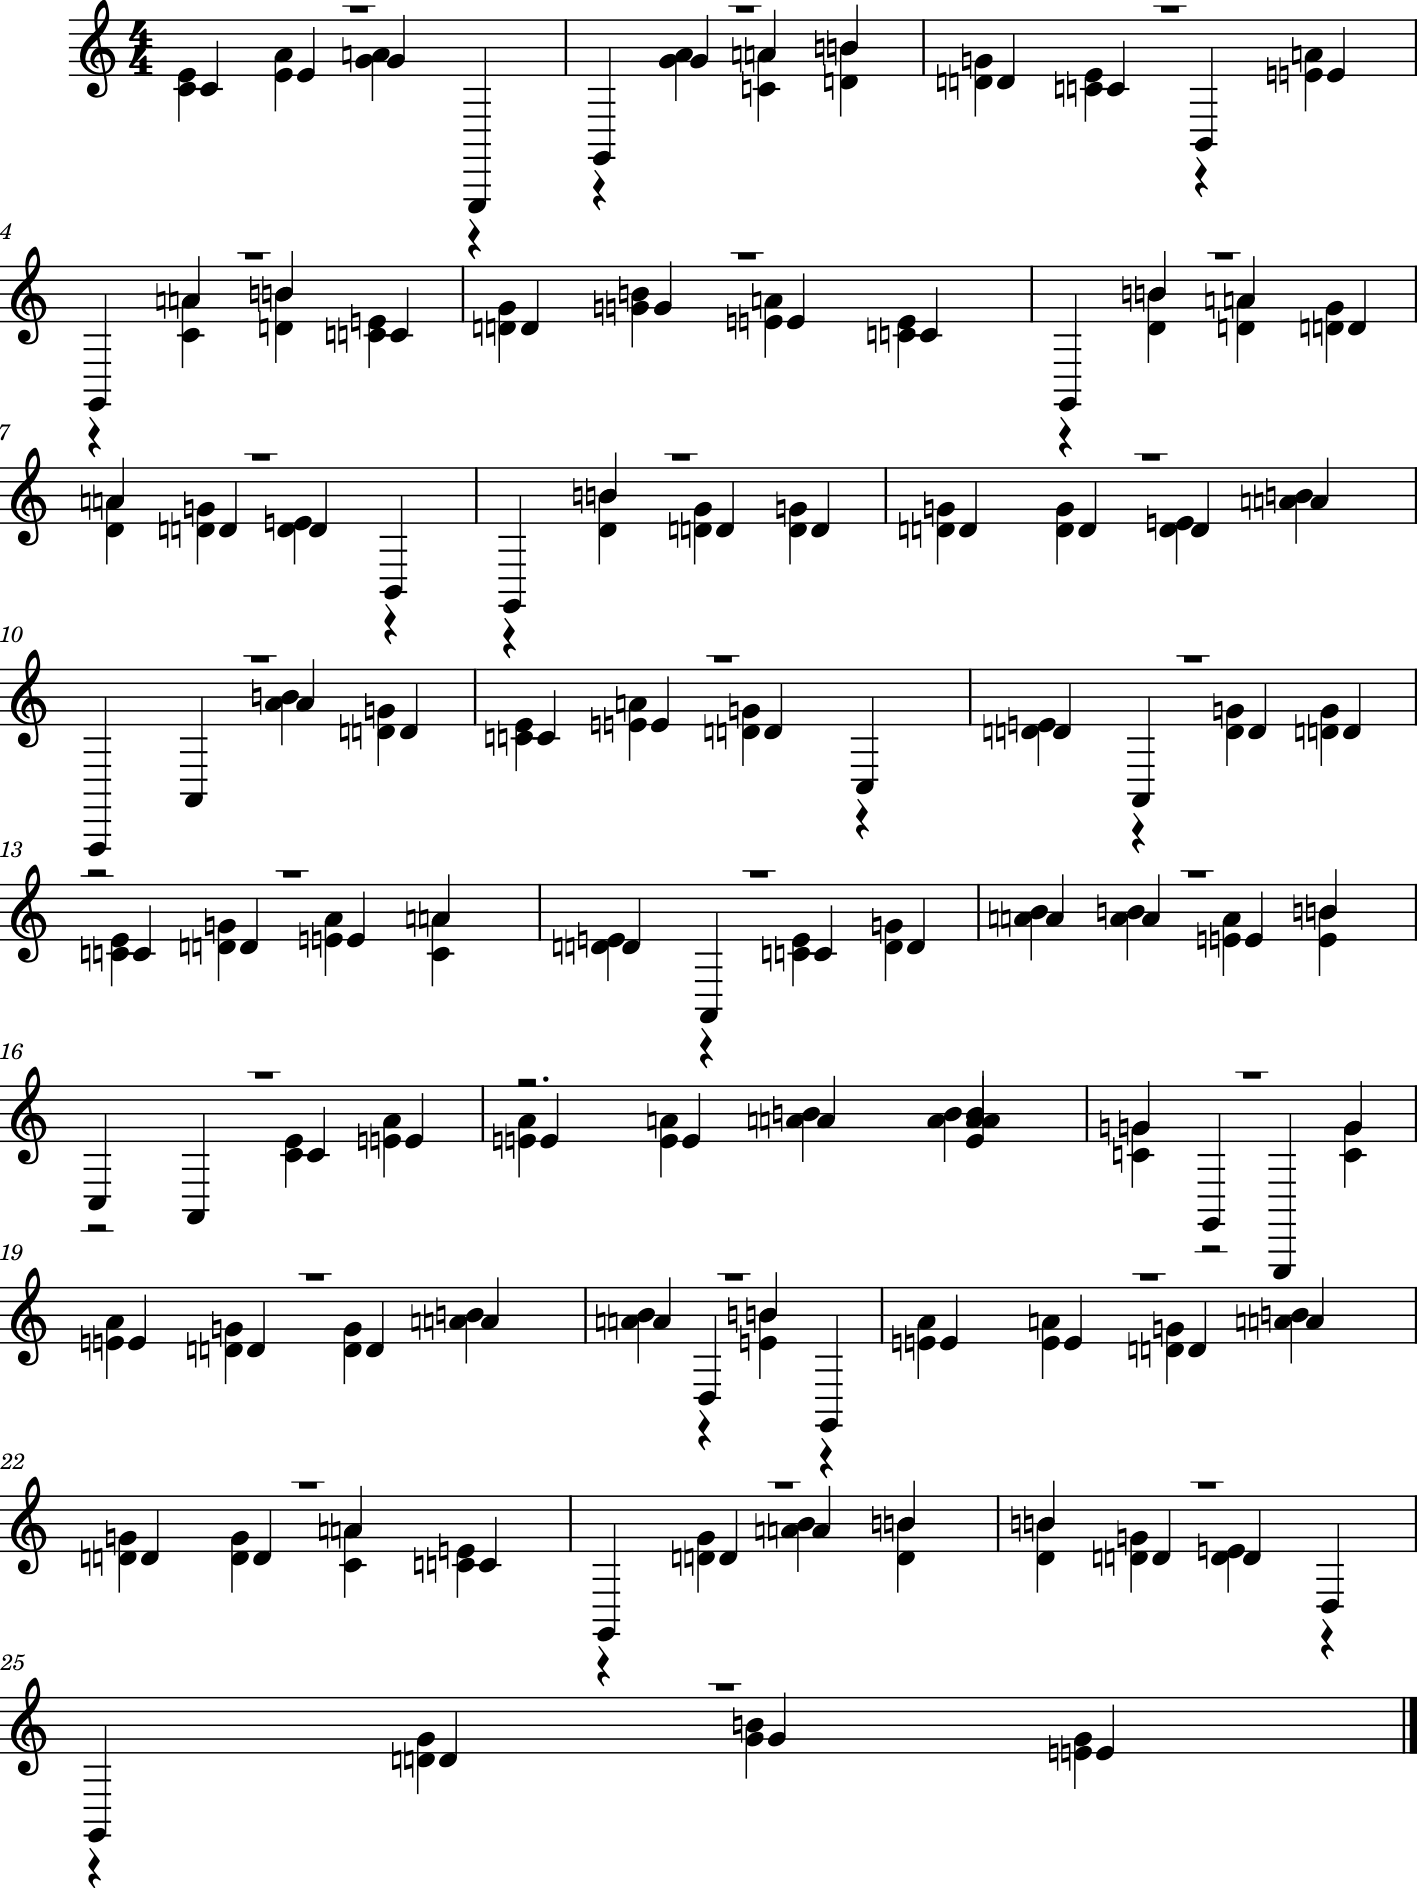

In [ ]:
Melody_Snippet = transform_to_notes_and_chords(songNotes[500:600])
Melody_Snippet.show()
Melody_Snippet.show('midi')

## Data pre-processing

First, we will save into a dictionary the number of times that a note or a chord appears in all the songs. This way we can also get the number of unique notes used.

In [ ]:
noteCounter = Counter(songNotes)
print('\033[1m' + 'Unique notes/chords:' + '\033[0m', len(noteCounter))

Unique notes/chords: 175


Now we will take a look at the most common notes, as this will be the most interesting to us whenever we start generating the actual music. We will plot the 25 most common ones.

However, for this milestone, we won't use this information. We will improve the data preprocessing for the final project by checking this information and giving these notes more importance when generating the song.

<BarContainer object of 25 artists>

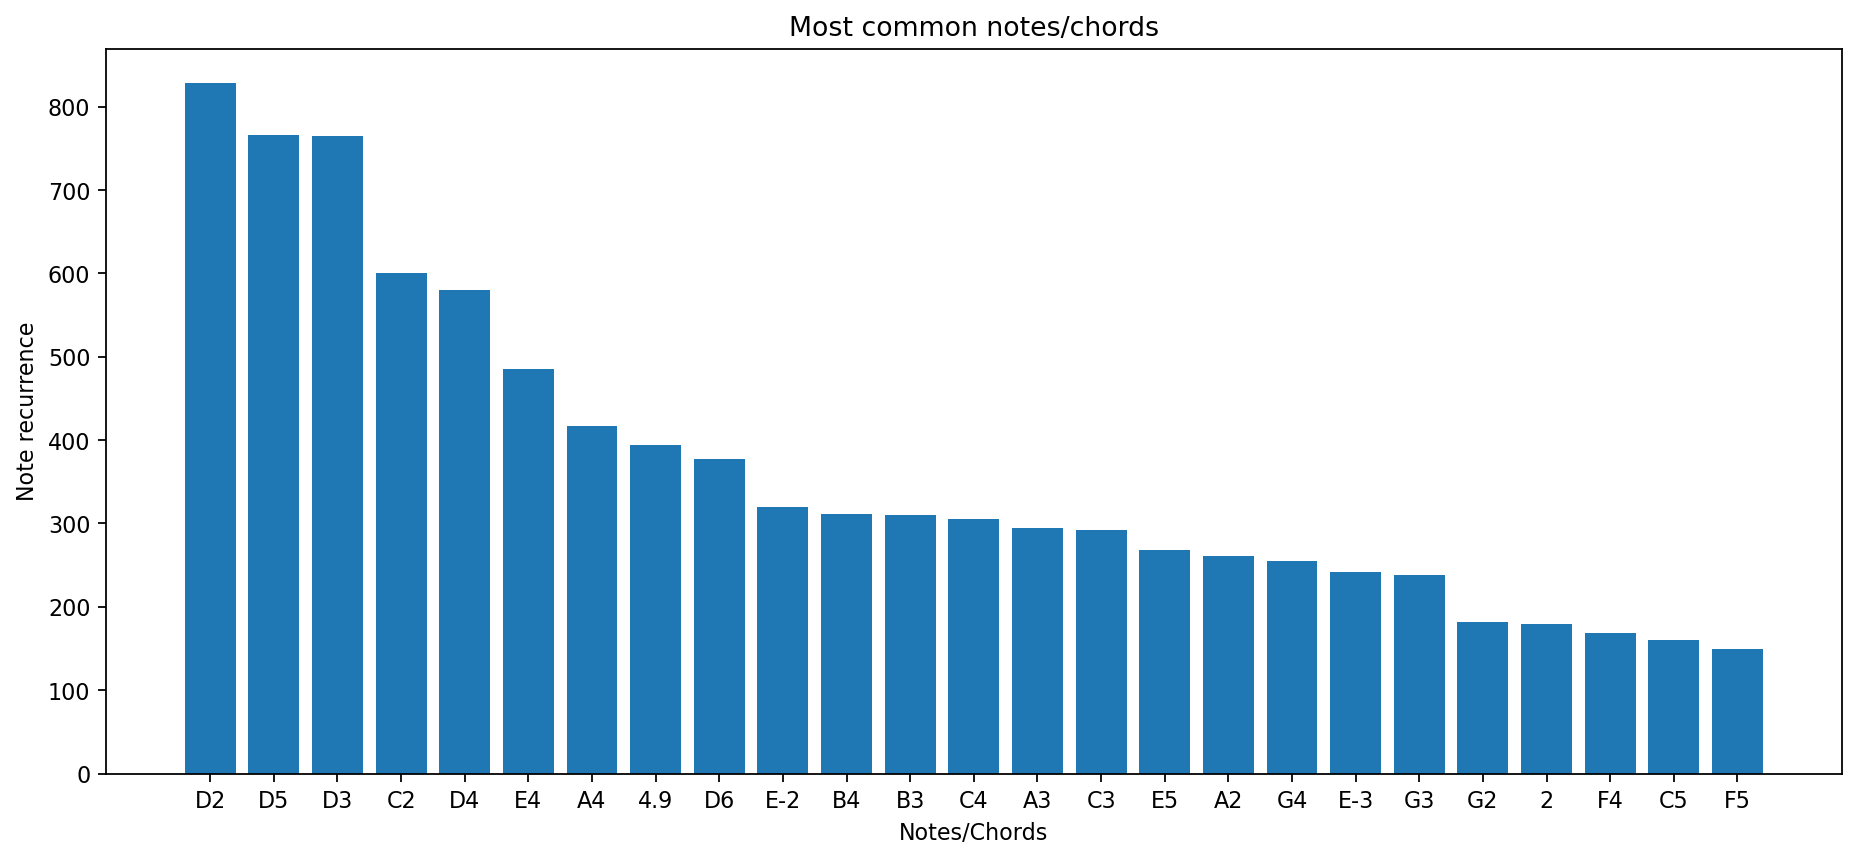

In [ ]:
commonNotes = noteCounter.most_common()
notes = []
noteRecurrence = []
for i in range(25):
    notes.append(commonNotes[i][0])
    noteRecurrence.append(commonNotes[i][1])
figure(figsize=(14, 6), dpi=80)
plt.title('Most common notes/chords')
plt.xlabel('Notes/Chords')
plt.ylabel('Note recurrence')
plt.bar(notes, noteRecurrence)

Now, we will delete the least common used notes from the songs.

In [ ]:
leastUsedNotes = []
for index, (key, value) in enumerate(noteCounter.items()):
    if value < 2:
        m =  key
        leastUsedNotes.append(m)
        
print("Notes that appear under 2 times:", len(leastUsedNotes))

Notes that appear under 2 times: 31


In [ ]:
for element in songNotes:
    if element in leastUsedNotes:
        songNotes.remove(element)

print("New length of notes:", len(songNotes))

New length of notes: 13536


Now we will start with the actual preprocessing of the data. The first thing we will do is to take the list of notes, and map all these notes to an integer, so that we can work with it in our model. For example, if we have the following list of notes:
![PreMap.png](attachment:PreMap.png)

The restult after the map would be something as the following:
![PostMap.png](attachment:PostMap.png)

In [ ]:
# First, we will save the unique characters/notes
uniqueCh = sorted(list(set(songNotes)))
songLen = len(songNotes) 
uniqueChLen = len(uniqueCh)

In [ ]:
# Dictionary for mapping the notes and reverse mapping
mapping = dict((c, i) for i, c in enumerate(uniqueCh))
reverseMapping = dict((i, c) for i, c in enumerate(uniqueCh))

After mapping all the notes to an integer, we will build the X and Y for training. For this part we will call the X: ***features*** and Y: ***target***. For our model, the ***features*** will be the sequence of notes that we already generated, and the ***target*** will be the prediction for the next note. We created the following animation to show how this works. In the animation we are just taking ***3*** notes for the prediction, but in our preprocessing we will take ***75***.

![AnimatedProcessing](AnimatedProcessing.gif)

In [ ]:
#Splitting the songs in equal length of strings and output target
splitLen = 75
features = []
targets = []
for pos in range(0, songLen - splitLen, 1):
    feature = songNotes[pos : (pos + splitLen)]
    target = songNotes[pos + splitLen]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
dataLen = len(targets)

Finally, we will reshape the features to get ***X***, and normalize it. We will also apply OHE to the target using the to_categorical function, and we will get the ***y***, so instead of having an integer as a target, we will have an array of zeros and a one in the position of the value of the target. With these we will train our model.

In [ ]:
# reshape X and normalize
X = (np.reshape(features, (dataLen, splitLen, 1)))/ float(uniqueChLen)
# OHE the output variable
y = to_categorical(targets) 

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model
Now we can create our model using LSTM (Long short-term memory) layers. This is a Recurrent Neural Network, which will take a sequence as an input (which are going to be the previous notes generated), and it's going to return another sequence.

We will build this model using multiple layers, so lets understand what each one of these are:
* **LSTM layers:** 
![LSTM_layer.png](attachment:LSTM_layer.png)

* **Dropout layers:** This is a regularization technique that prevents overfitting. In our case, in case of overfitting, we would be generating the same songs as the input. To prevent this to happen, this layer sets some of the values of the input to 0 at each update. The number of elements that are set to 0 depends on the parameter that we pass into the funciton to generate this layer.
![Dropout.png](attachment:Dropout.png)



* **Dense layers:** These are the layers of a fully connected neural network, where each of the input nodes are connected to the output nodes.
![Dense.jpeg](attachment:Dense.jpeg)

* **Activation layer:** This layer determines the activation function for our neural network, which will be used to calculate the output of a node. There are multiple activation functions, so we will try multiple ones to test which one works better.

In [ ]:
def createModel(dropoutVal):
    # Define the model architecture
    model = Sequential()

    model.add(LSTM(
        256, #Increased number of neurons
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(dropoutVal))
    model.add(LSTM(512))
    model.add(Dense(256))
    model.add(Dropout(dropoutVal))
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))
    return model

We will use ***Categorical Cross-Entropy loss*** (also known as ***Softmax loss***) to evaluate our model, as we have a categorical output. So, this is the case of a multi-class classification where the labels are one-hot encoded, and there is only one element in the target vector that is non-zero. This loss is calculated using the tensorflow library.

Epoch 1/75
43/43 [==============================] - 88s 2s/step - loss: 4.4110 - val_loss: 4.5481
Epoch 2/75
43/43 [==============================] - 91s 2s/step - loss: 4.1009 - val_loss: 4.0461
Epoch 3/75
43/43 [==============================] - 88s 2s/step - loss: 3.9347 - val_loss: 4.1504
Epoch 4/75
43/43 [==============================] - 86s 2s/step - loss: 3.9138 - val_loss: 4.2413
Epoch 5/75
43/43 [==============================] - 86s 2s/step - loss: 3.8424 - val_loss: 3.8943
Epoch 6/75
43/43 [==============================] - 86s 2s/step - loss: 3.8129 - val_loss: 3.9390
Epoch 7/75
43/43 [==============================] - 91s 2s/step - loss: 3.7882 - val_loss: 3.8865
Epoch 8/75
43/43 [==============================] - 115s 3s/step - loss: 3.7562 - val_loss: 3.9342
Epoch 9/75
43/43 [==============================] - 119s 3s/step - loss: 3.6951 - val_loss: 3.8210
Epoch 10/75
43/43 [==============================] - 115s 3s/step - loss: 3.6643 - val_loss: 4.1014
Epoch 11/75
43/4

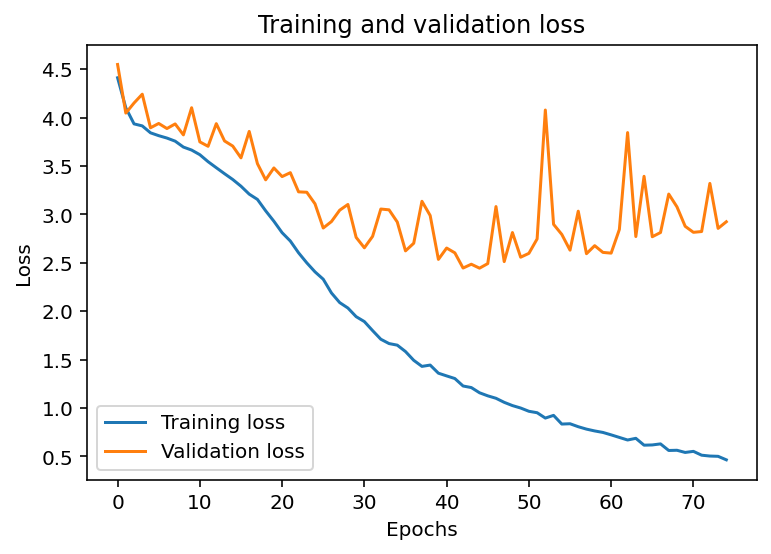

Epoch 1/75
43/43 [==============================] - 105s 2s/step - loss: 4.4579 - val_loss: 4.5407
Epoch 2/75
43/43 [==============================] - 99s 2s/step - loss: 4.1460 - val_loss: 4.1108
Epoch 3/75
43/43 [==============================] - 100s 2s/step - loss: 3.9979 - val_loss: 3.9674
Epoch 4/75
43/43 [==============================] - 100s 2s/step - loss: 3.9232 - val_loss: 4.1183
Epoch 5/75
43/43 [==============================] - 99s 2s/step - loss: 3.9093 - val_loss: 3.8676
Epoch 6/75
43/43 [==============================] - 101s 2s/step - loss: 3.8588 - val_loss: 3.8534
Epoch 7/75
43/43 [==============================] - 102s 2s/step - loss: 3.8114 - val_loss: 3.7947
Epoch 8/75
43/43 [==============================] - 101s 2s/step - loss: 3.7940 - val_loss: 3.8049
Epoch 9/75
43/43 [==============================] - 101s 2s/step - loss: 3.7297 - val_loss: 3.9060
Epoch 10/75
43/43 [==============================] - 102s 2s/step - loss: 3.6860 - val_loss: 3.8746
Epoch 11/75

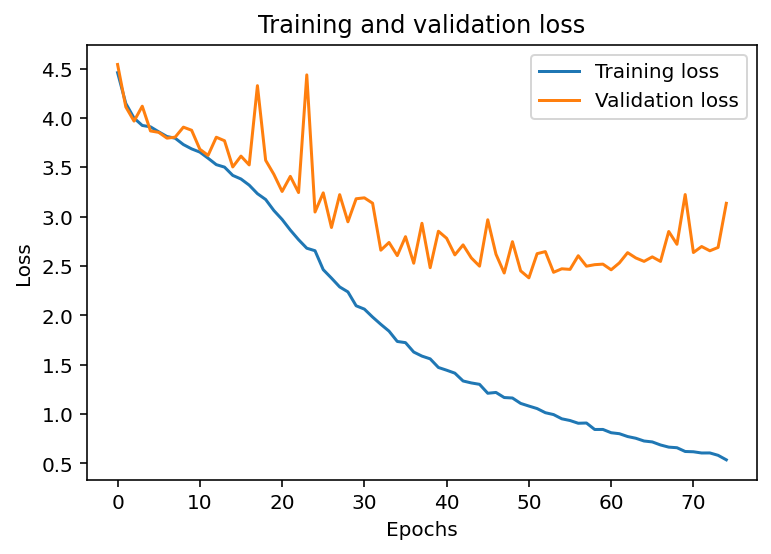

Epoch 1/75
43/43 [==============================] - 101s 2s/step - loss: 4.4799 - val_loss: 4.2271
Epoch 2/75
43/43 [==============================] - 96s 2s/step - loss: 4.1253 - val_loss: 3.9968
Epoch 3/75
43/43 [==============================] - 98s 2s/step - loss: 3.9888 - val_loss: 3.9446
Epoch 4/75
43/43 [==============================] - 99s 2s/step - loss: 3.9254 - val_loss: 4.0098
Epoch 5/75
43/43 [==============================] - 92s 2s/step - loss: 3.8969 - val_loss: 3.8665
Epoch 6/75
43/43 [==============================] - 95s 2s/step - loss: 3.8613 - val_loss: 5.2315
Epoch 7/75
43/43 [==============================] - 97s 2s/step - loss: 3.8585 - val_loss: 4.1056
Epoch 8/75
43/43 [==============================] - 97s 2s/step - loss: 3.8066 - val_loss: 4.0305
Epoch 9/75
43/43 [==============================] - 97s 2s/step - loss: 3.7866 - val_loss: 3.9052
Epoch 10/75
43/43 [==============================] - 96s 2s/step - loss: 3.7509 - val_loss: 3.7737
Epoch 11/75
43/43 

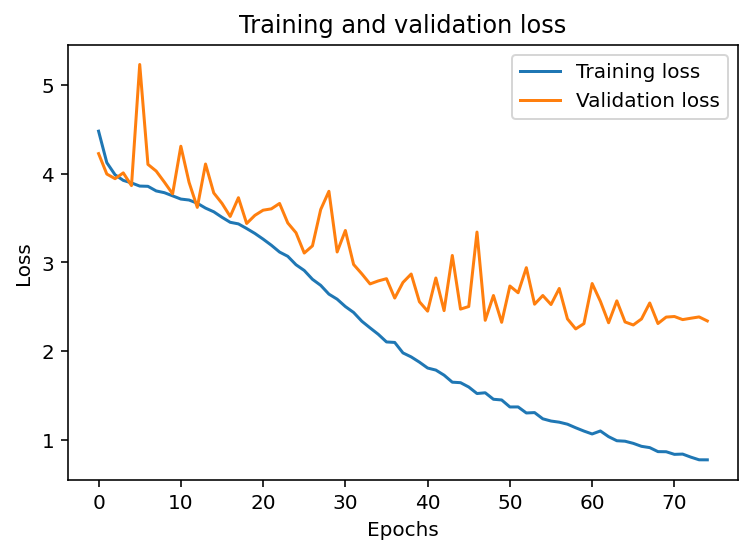

Epoch 1/75
43/43 [==============================] - 105s 2s/step - loss: 4.5098 - val_loss: 4.0973
Epoch 2/75
43/43 [==============================] - 100s 2s/step - loss: 4.1599 - val_loss: 4.0096
Epoch 3/75
43/43 [==============================] - 103s 2s/step - loss: 4.0354 - val_loss: 4.1976
Epoch 4/75
43/43 [==============================] - 103s 2s/step - loss: 3.9742 - val_loss: 3.9471
Epoch 5/75
43/43 [==============================] - 101s 2s/step - loss: 3.9439 - val_loss: 3.8765
Epoch 6/75
43/43 [==============================] - 102s 2s/step - loss: 3.9158 - val_loss: 3.8728
Epoch 7/75
43/43 [==============================] - 102s 2s/step - loss: 3.8837 - val_loss: 3.8334
Epoch 8/75
43/43 [==============================] - 101s 2s/step - loss: 3.8575 - val_loss: 3.8240
Epoch 9/75
43/43 [==============================] - 101s 2s/step - loss: 3.8431 - val_loss: 3.7956
Epoch 10/75
43/43 [==============================] - 102s 2s/step - loss: 3.8197 - val_loss: 3.8612
Epoch 11/

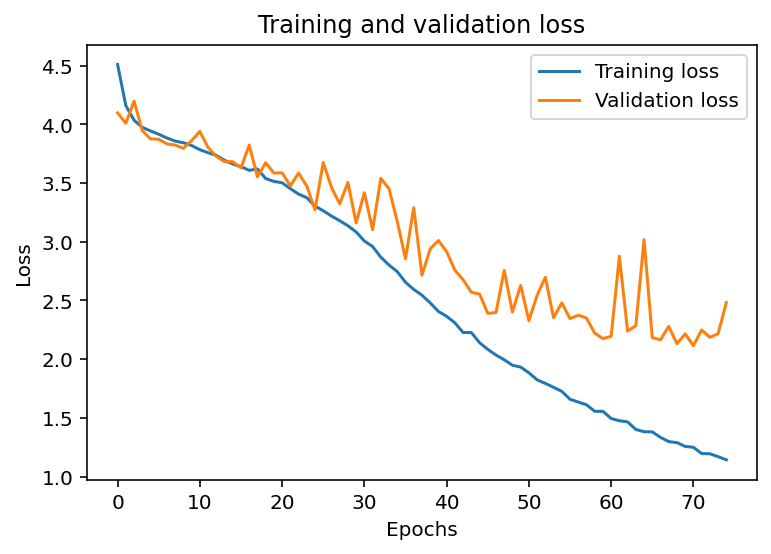

In [ ]:
dropouts = [0.1, 0.3, 0.5, 0.7]
for val in dropouts:
    model = createModel(val)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')    
    savedModel = model.fit(X, y, epochs=75, batch_size=256, validation_data=(X_test, y_test))
    loss = savedModel.history['loss']
    val_loss = savedModel.history['val_loss']

    figure()
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/75
85/85 [==============================] - 123s 1s/step - loss: 4.2823 - val_loss: 3.9781
Epoch 2/75
85/85 [==============================] - 122s 1s/step - loss: 3.9626 - val_loss: 3.9359
Epoch 3/75
85/85 [==============================] - 109s 1s/step - loss: 3.8797 - val_loss: 3.9774
Epoch 4/75
85/85 [==============================] - 108s 1s/step - loss: 3.8349 - val_loss: 4.1386
Epoch 5/75
85/85 [==============================] - 108s 1s/step - loss: 3.7760 - val_loss: 4.0689
Epoch 6/75
85/85 [==============================] - 108s 1s/step - loss: 3.7009 - val_loss: 3.7180
Epoch 7/75
85/85 [==============================] - 107s 1s/step - loss: 3.6228 - val_loss: 4.7624
Epoch 8/75
85/85 [==============================] - 109s 1s/step - loss: 3.5417 - val_loss: 3.6535
Epoch 9/75
85/85 [==============================] - 116s 1s/step - loss: 3.4375 - val_loss: 3.5312
Epoch 10/75
85/85 [==============================] - 115s 1s/step - loss: 3.3258 - val_loss: 3.4987
Epoch 11/

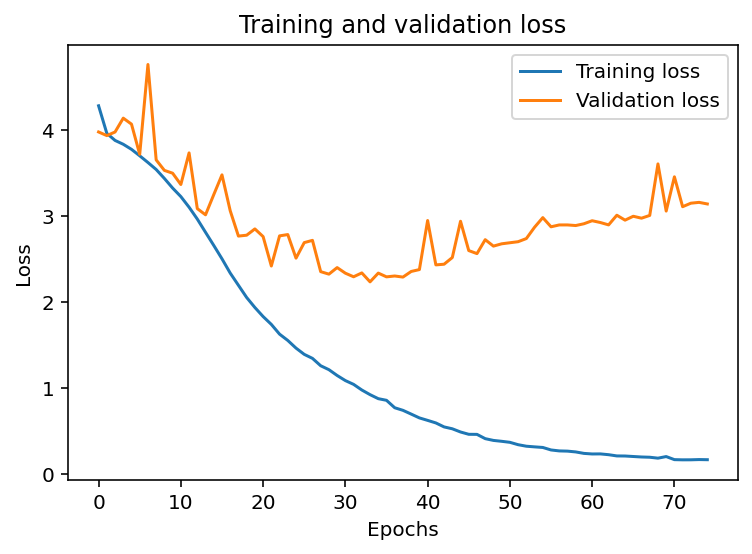

Epoch 1/75
85/85 [==============================] - 122s 1s/step - loss: 4.2552 - val_loss: 4.0656
Epoch 2/75
85/85 [==============================] - 115s 1s/step - loss: 3.9753 - val_loss: 3.9169
Epoch 3/75
85/85 [==============================] - 115s 1s/step - loss: 3.8969 - val_loss: 3.9090
Epoch 4/75
85/85 [==============================] - 115s 1s/step - loss: 3.8444 - val_loss: 4.1548
Epoch 5/75
85/85 [==============================] - 118s 1s/step - loss: 3.8064 - val_loss: 3.8714
Epoch 6/75
85/85 [==============================] - 114s 1s/step - loss: 3.7509 - val_loss: 3.7417
Epoch 7/75
85/85 [==============================] - 113s 1s/step - loss: 3.6825 - val_loss: 4.7091
Epoch 8/75
85/85 [==============================] - 111s 1s/step - loss: 3.6218 - val_loss: 3.7598
Epoch 9/75
85/85 [==============================] - 111s 1s/step - loss: 3.5896 - val_loss: 3.6668
Epoch 10/75
85/85 [==============================] - 106s 1s/step - loss: 3.4939 - val_loss: 3.6397
Epoch 11/

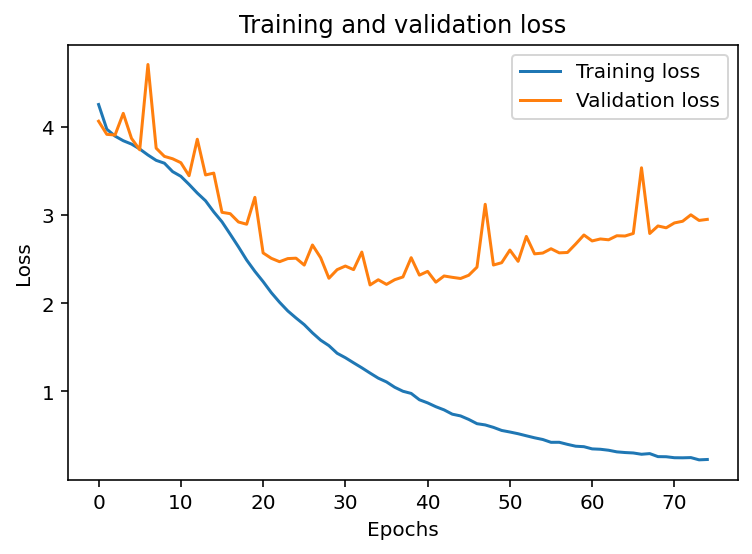

Epoch 1/75
85/85 [==============================] - 109s 1s/step - loss: 4.3209 - val_loss: 4.1061
Epoch 2/75
85/85 [==============================] - 102s 1s/step - loss: 3.9985 - val_loss: 4.0513
Epoch 3/75
85/85 [==============================] - 104s 1s/step - loss: 3.9127 - val_loss: 3.9838
Epoch 4/75
85/85 [==============================] - 101s 1s/step - loss: 3.8566 - val_loss: 3.8067
Epoch 5/75
85/85 [==============================] - 100s 1s/step - loss: 3.8362 - val_loss: 3.9245
Epoch 6/75
85/85 [==============================] - 101s 1s/step - loss: 3.7860 - val_loss: 3.7907
Epoch 7/75
85/85 [==============================] - 102s 1s/step - loss: 3.7382 - val_loss: 3.7239
Epoch 8/75
85/85 [==============================] - 106s 1s/step - loss: 3.6854 - val_loss: 3.7151
Epoch 9/75
85/85 [==============================] - 101s 1s/step - loss: 3.6073 - val_loss: 3.6369
Epoch 10/75
85/85 [==============================] - 101s 1s/step - loss: 3.5271 - val_loss: 3.6350
Epoch 11/

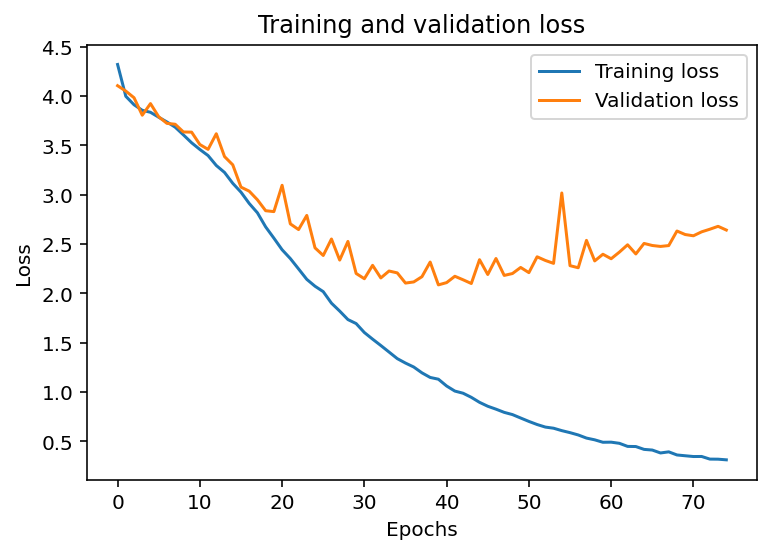

Epoch 1/75
85/85 [==============================] - 112s 1s/step - loss: 4.3381 - val_loss: 4.0531
Epoch 2/75
85/85 [==============================] - 109s 1s/step - loss: 4.0784 - val_loss: 4.0792
Epoch 3/75
85/85 [==============================] - 108s 1s/step - loss: 3.9691 - val_loss: 3.9110
Epoch 4/75
85/85 [==============================] - 108s 1s/step - loss: 3.9210 - val_loss: 3.8475
Epoch 5/75
85/85 [==============================] - 108s 1s/step - loss: 3.8862 - val_loss: 4.2153
Epoch 6/75
85/85 [==============================] - 103s 1s/step - loss: 3.8702 - val_loss: 3.9767
Epoch 7/75
85/85 [==============================] - 102s 1s/step - loss: 3.8379 - val_loss: 4.1346
Epoch 8/75
85/85 [==============================] - 102s 1s/step - loss: 3.8289 - val_loss: 3.8844
Epoch 9/75
85/85 [==============================] - 103s 1s/step - loss: 3.7755 - val_loss: 3.8805
Epoch 10/75
85/85 [==============================] - 106s 1s/step - loss: 3.7462 - val_loss: 3.6912
Epoch 11/

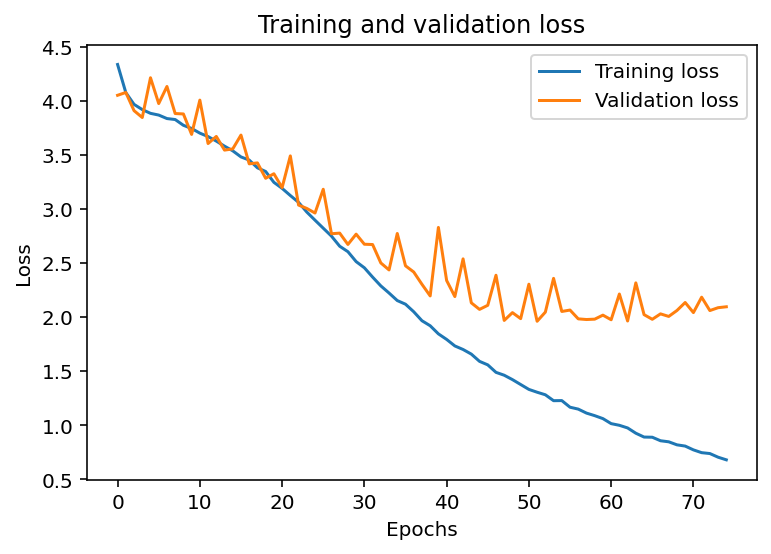

In [ ]:
dropouts = [0.1, 0.3, 0.5, 0.7]
for val in dropouts:
    model = createModel(val)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')    
    savedModel = model.fit(X, y, epochs=75, batch_size=128, validation_data=(X_test, y_test))
    loss = savedModel.history['loss']
    val_loss = savedModel.history['val_loss']

    figure()
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/40
43/43 [==============================] - 85s 2s/step - loss: 4.4414 - val_loss: 4.3301
Epoch 2/40
43/43 [==============================] - 86s 2s/step - loss: 4.1095 - val_loss: 4.1354
Epoch 3/40
43/43 [==============================] - 88s 2s/step - loss: 3.9667 - val_loss: 4.0411
Epoch 4/40
43/43 [==============================] - 95s 2s/step - loss: 3.9044 - val_loss: 3.9225
Epoch 5/40
43/43 [==============================] - 109s 3s/step - loss: 3.8582 - val_loss: 4.0583
Epoch 6/40
43/43 [==============================] - 104s 2s/step - loss: 3.8362 - val_loss: 3.9307
Epoch 7/40
43/43 [==============================] - 111s 3s/step - loss: 3.7770 - val_loss: 3.9676
Epoch 8/40
43/43 [==============================] - 111s 3s/step - loss: 3.7381 - val_loss: 3.9241
Epoch 9/40
43/43 [==============================] - 99s 2s/step - loss: 3.7177 - val_loss: 3.8314
Epoch 10/40
43/43 [==============================] - 110s 3s/step - loss: 3.6416 - val_loss: 3.8217
Epoch 11/40
43

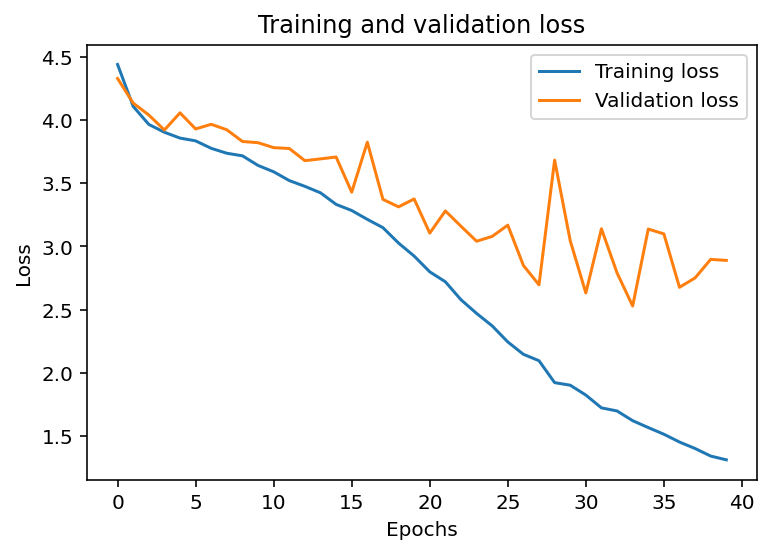

Epoch 1/40
43/43 [==============================] - 106s 2s/step - loss: 4.4221 - val_loss: 4.2103
Epoch 2/40
43/43 [==============================] - 95s 2s/step - loss: 4.1008 - val_loss: 4.2531
Epoch 3/40
43/43 [==============================] - 95s 2s/step - loss: 3.9981 - val_loss: 3.9672
Epoch 4/40
43/43 [==============================] - 100s 2s/step - loss: 3.9187 - val_loss: 3.9765
Epoch 5/40
43/43 [==============================] - 101s 2s/step - loss: 3.8704 - val_loss: 3.9446
Epoch 6/40
43/43 [==============================] - 96s 2s/step - loss: 3.8415 - val_loss: 3.7953
Epoch 7/40
43/43 [==============================] - 96s 2s/step - loss: 3.8197 - val_loss: 3.8205
Epoch 8/40
43/43 [==============================] - 92s 2s/step - loss: 3.7654 - val_loss: 3.9422
Epoch 9/40
43/43 [==============================] - 99s 2s/step - loss: 3.7254 - val_loss: 4.4994
Epoch 10/40
43/43 [==============================] - 100s 2s/step - loss: 3.6922 - val_loss: 3.6884
Epoch 11/40
43/

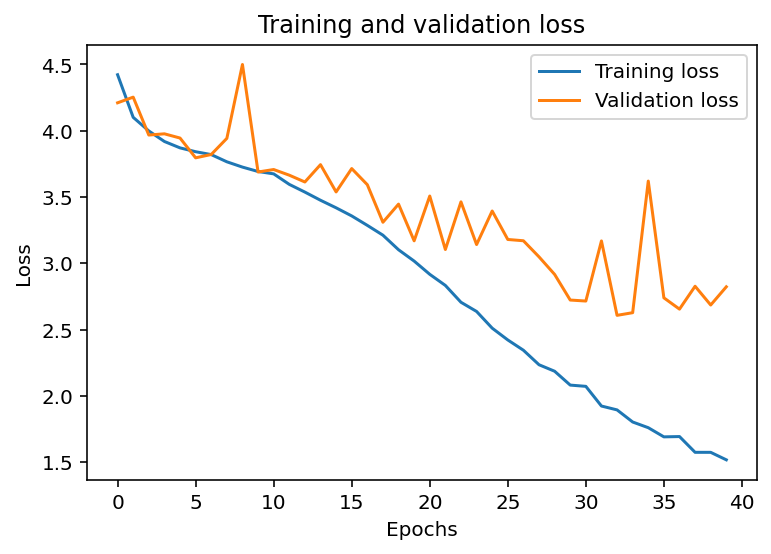

Epoch 1/40
43/43 [==============================] - 280s 6s/step - loss: 4.4010 - val_loss: 4.1679
Epoch 2/40
43/43 [==============================] - 264s 6s/step - loss: 4.2248 - val_loss: 4.0767
Epoch 3/40
43/43 [==============================] - 263s 6s/step - loss: 4.0024 - val_loss: 3.9762
Epoch 4/40
43/43 [==============================] - 260s 6s/step - loss: 3.9561 - val_loss: 3.9444
Epoch 5/40
43/43 [==============================] - 267s 6s/step - loss: 3.9037 - val_loss: 3.9542
Epoch 6/40
43/43 [==============================] - 259s 6s/step - loss: 3.8759 - val_loss: 3.8974
Epoch 7/40
43/43 [==============================] - 265s 6s/step - loss: 3.8361 - val_loss: 3.9473
Epoch 8/40
43/43 [==============================] - 263s 6s/step - loss: 3.8138 - val_loss: 3.8093
Epoch 9/40
43/43 [==============================] - 274s 6s/step - loss: 3.8379 - val_loss: 3.7921
Epoch 10/40
43/43 [==============================] - 263s 6s/step - loss: 3.7360 - val_loss: 3.8533
Epoch 11/

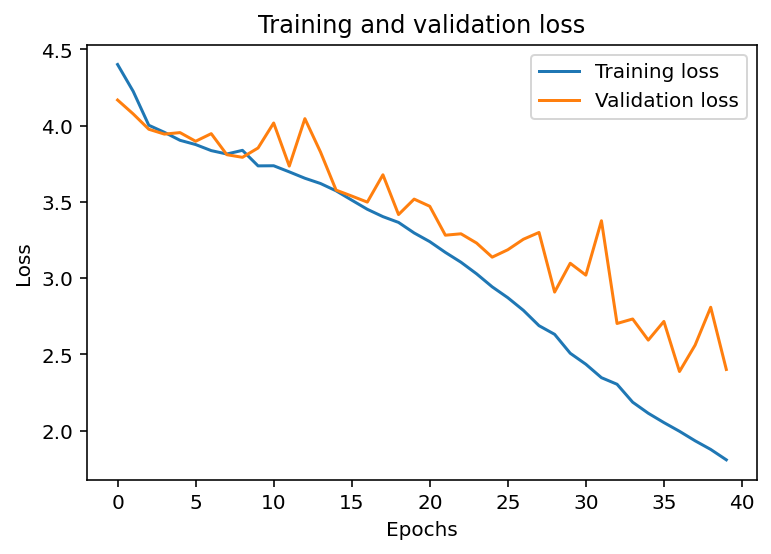

Epoch 1/40
43/43 [==============================] - 186s 4s/step - loss: 4.5172 - val_loss: 4.1366
Epoch 2/40
43/43 [==============================] - 176s 4s/step - loss: 4.2228 - val_loss: 4.0606
Epoch 3/40
43/43 [==============================] - 219s 5s/step - loss: 4.0776 - val_loss: 3.9355
Epoch 4/40
43/43 [==============================] - 216s 5s/step - loss: 3.9869 - val_loss: 3.8933
Epoch 5/40
43/43 [==============================] - 225s 5s/step - loss: 3.9394 - val_loss: 4.2910
Epoch 6/40
43/43 [==============================] - 221s 5s/step - loss: 3.9327 - val_loss: 3.8916
Epoch 7/40
43/43 [==============================] - 225s 5s/step - loss: 3.8858 - val_loss: 4.0369
Epoch 8/40
43/43 [==============================] - 221s 5s/step - loss: 3.8883 - val_loss: 3.8545
Epoch 9/40
43/43 [==============================] - 227s 5s/step - loss: 3.8634 - val_loss: 3.8114
Epoch 10/40
43/43 [==============================] - 227s 5s/step - loss: 3.8324 - val_loss: 3.8361
Epoch 11/

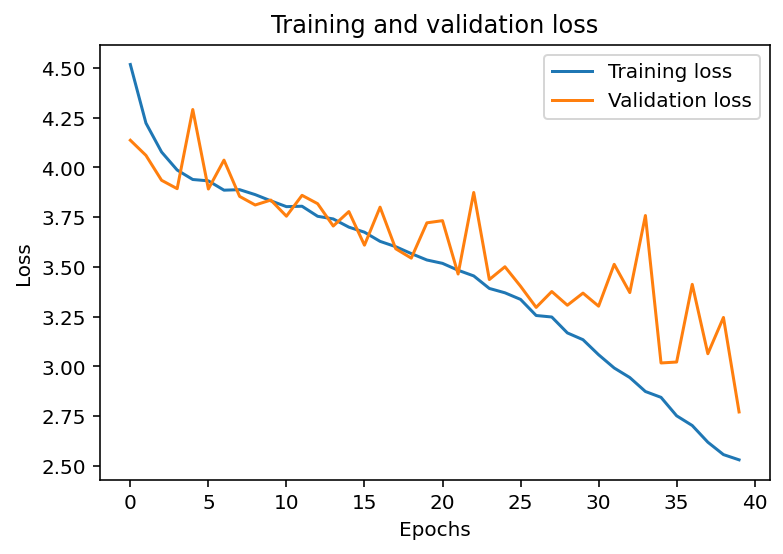

In [ ]:
dropouts = [0.1, 0.3, 0.5, 0.7]
for val in dropouts:
    model = createModel(val)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')    
    savedModel = model.fit(X, y, epochs=40, batch_size=256, validation_data=(X_test, y_test))
    loss = savedModel.history['loss']
    val_loss = savedModel.history['val_loss']

    figure()
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Song generation
Based on the results we obtained, we will train the model that we chose and generate the song

In [ ]:
model = createModel(0.5)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')    
savedModel = model.fit(X, y, epochs=75, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/75
34/34 [==============================] - 97s 3s/step - loss: 4.5472 - val_loss: 4.3262
Epoch 2/75
34/34 [==============================] - 88s 3s/step - loss: 4.2329 - val_loss: 4.0067
Epoch 3/75
34/34 [==============================] - 88s 3s/step - loss: 4.0689 - val_loss: 3.9165
Epoch 4/75
34/34 [==============================] - 84s 2s/step - loss: 3.9709 - val_loss: 3.9487
Epoch 5/75
34/34 [==============================] - 85s 3s/step - loss: 3.9456 - val_loss: 3.9592
Epoch 6/75
34/34 [==============================] - 87s 3s/step - loss: 3.8963 - val_loss: 3.8500
Epoch 7/75
34/34 [==============================] - 86s 3s/step - loss: 3.8632 - val_loss: 3.8015
Epoch 8/75
34/34 [==============================] - 86s 3s/step - loss: 3.8409 - val_loss: 3.8168
Epoch 9/75
34/34 [==============================] - 87s 3s/step - loss: 3.8088 - val_loss: 3.8227
Epoch 10/75
34/34 [==============================] - 84s 2s/step - loss: 3.8045 - val_loss: 3.7786
Epoch 11/75
34/34 [

In [ ]:
# Take a section of X to use as the beginning of our generated song
X, X_init, y, y_init = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
def Song_Generator(noteNum):
    """ This function generate the list of notes generating a song using the previously
    trained model
    
    Args:
        noteNum: integer representing the total number of notes we want in our output
        song
    
    Returns:
        songStream: a music21.stream.Stream that contains the notes of the generated
        song
    
    """
    seed = X_init[np.random.randint(0,len(X_init)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(noteNum):
        seed = seed.reshape(1,splitLen,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(uniqueChLen)   
        Notes_Generated.append(index)  
        Music = [reverseMapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    song = transform_to_notes_and_chords(Music)
    songStream = stream.Stream(song)   
    return songStream

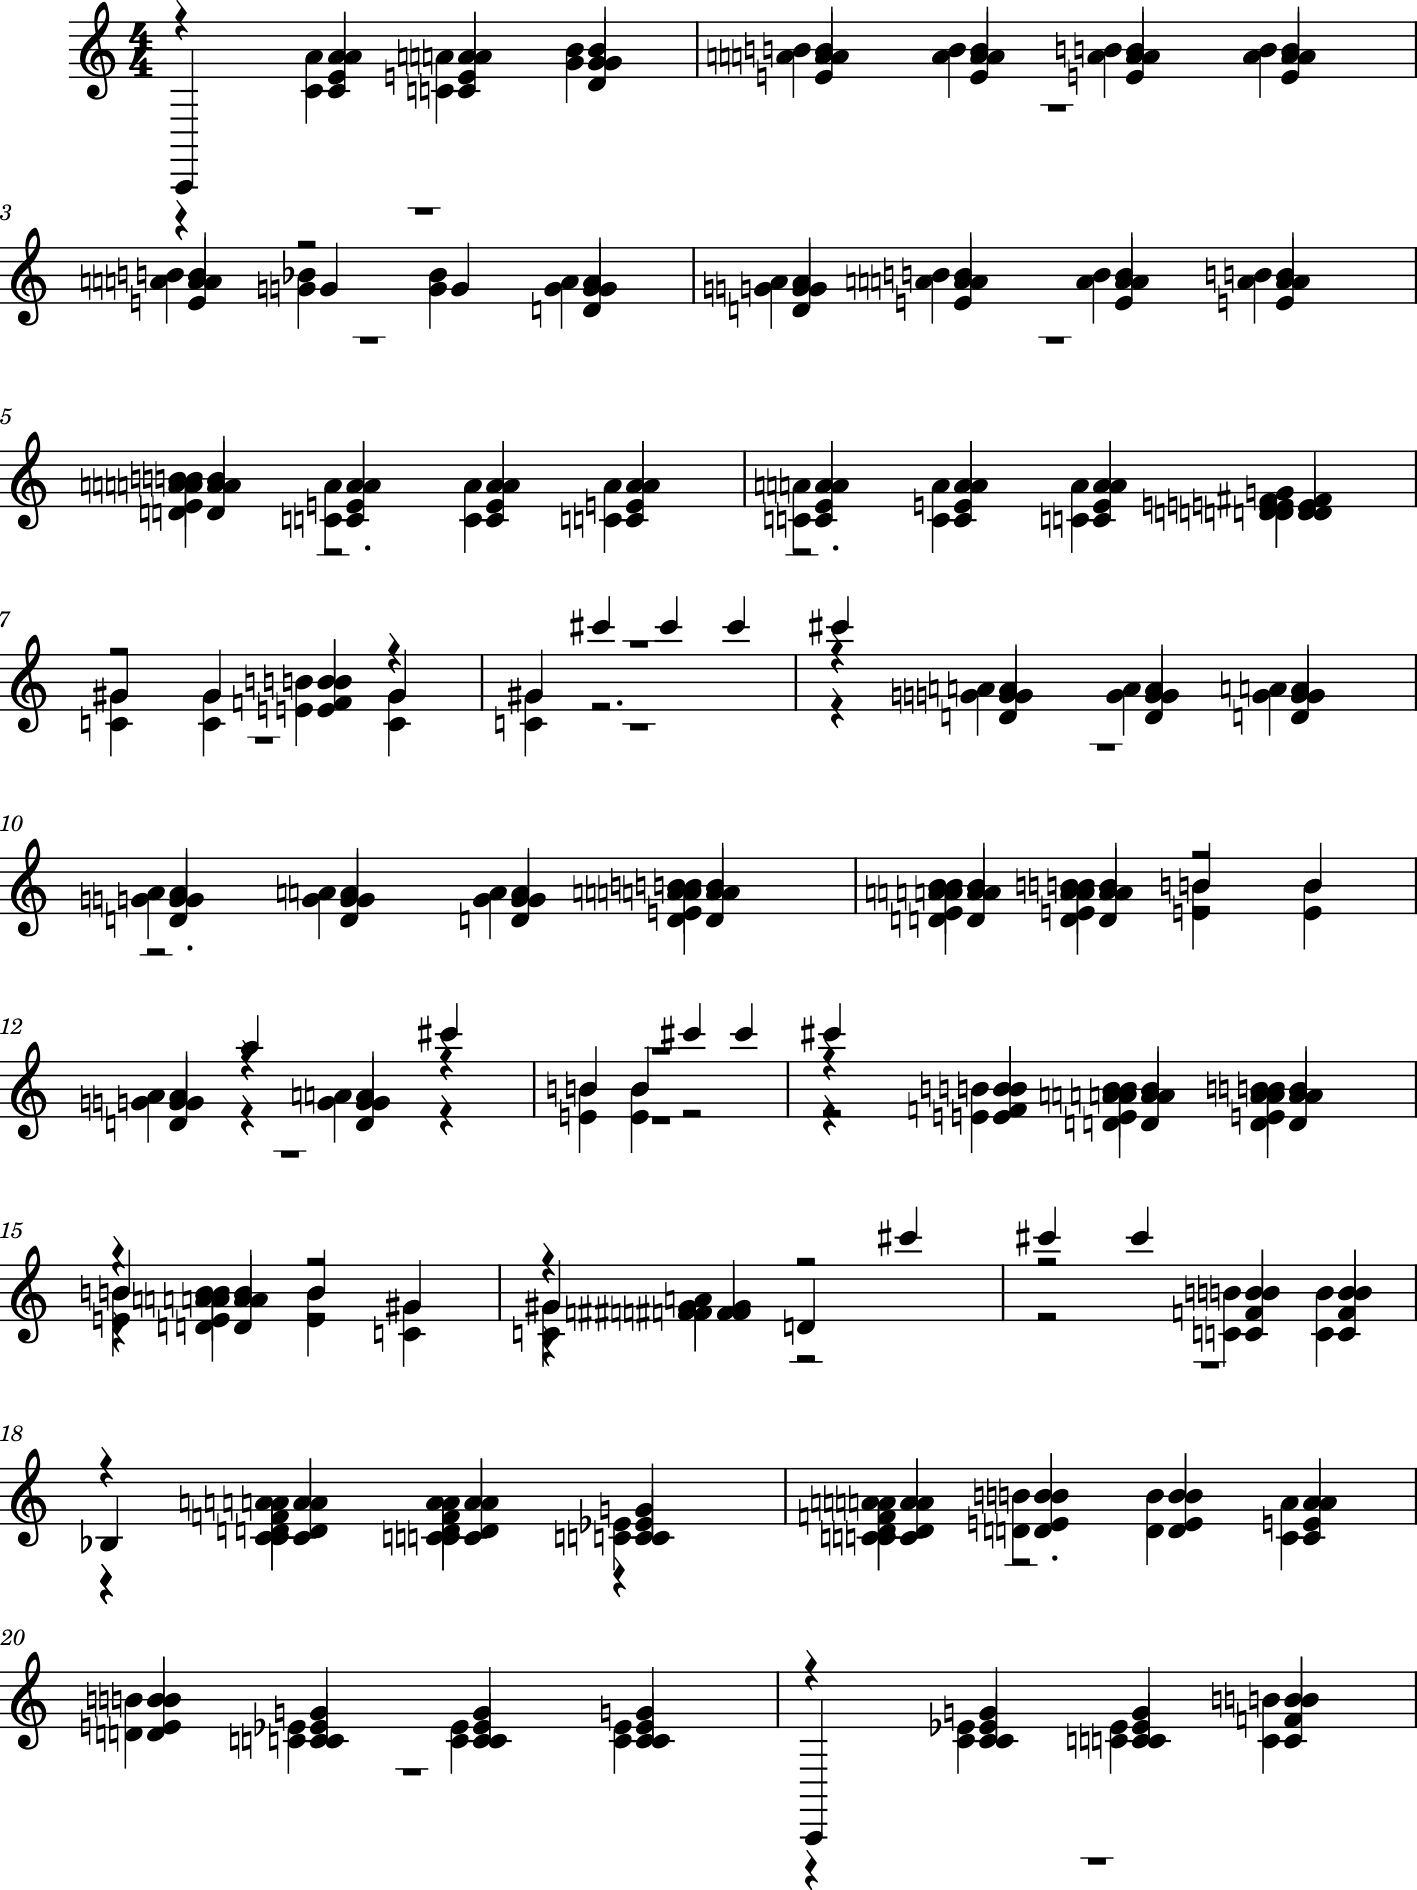

In [ ]:
# Generation of the song
finalSong = Song_Generator(250)
finalSong.show()

In [ ]:
finalSong.show('midi')

In [ ]:
# Save the song into a midi file
finalSong.write('midi', 'FinalSong.mid')

'FinalSong.mid'